Assigning voxels in PET image at each timepoint based on the midpoint regions

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
# print arrays to 4 decimal places
np.set_printoptions(precision=4, suppress=True)
import numpy.linalg as npl
import nibabel as nib
from nibabel.affines import apply_affine

Set params for pyplot

In [2]:
#plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

load deformation field which for each voxel in midpoint T1 space, has corresponding voxel scanner space coordinates in mm (x,y,z). Loading midpoint -> baseline pet first. 

In [3]:
mid_to_bl_img = nib.load('data/sub-10015124_midpoint-spm_to_baseline-pet_def.nii.gz')
mid_to_bl_data = mid_to_bl_img.get_fdata()
mid_to_bl_data.shape

mid_to_fu_img = nib.load('data/sub-10015124_midpoint-spm_to_followup-pet_def.nii.gz')
mid_to_fu_data = mid_to_fu_img.get_fdata()
mid_to_fu_data.shape

(216, 278, 280, 1, 3)

remove extra 4th dim of '1'. This is just some artefact of nifti format

In [4]:
mid_to_bl_data = np.squeeze(mid_to_bl_data)
mid_to_bl_data.shape

mid_to_fu_data = np.squeeze(mid_to_fu_data)
mid_to_fu_data.shape

(216, 278, 280, 3)

load midpoint GIF labels
whole cerebellum roi GIF indices


In [5]:
mid_lab_img = nib.load('data/sub-10015124_ses-midpoint_T1w_run-1_desc-gradwarp_spm-midpoint_labels_masked.nii.gz')
mid_lab_data = mid_lab_img.get_fdata()
mid_lab_data.shape

(216, 278, 280)

make mask from cerebellum gif labels
whole cerebellum roi GIF indices: 39,40,41,42,72,73,74

In [6]:
ref_roi_ind = [39,40,41,42,72,73,74]

In [7]:
ref_roi_mask = ((mid_lab_data == 39) | 
                (mid_lab_data == 40) | 
                (mid_lab_data == 41) | 
                (mid_lab_data == 42) | 
                (mid_lab_data == 72) | 
                (mid_lab_data == 73) | 
                (mid_lab_data == 74))

try creating masked array

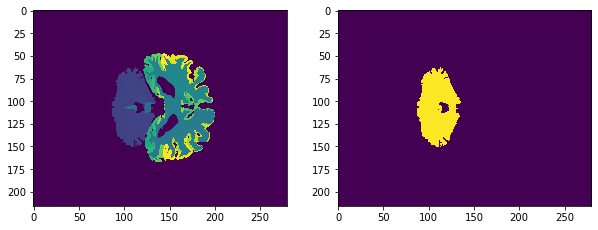

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mid_lab_data[:, 100, :])
axes[1].imshow(ref_roi_mask[:, 100, :])

get shape of roi

Iterate over voxels in mask and label them from 1 to n

In [9]:
n=1

# create version of mask that isn't bool
ref_roi_mask_int = np.array(ref_roi_mask, dtype = int)

#iterate adding 1
with np.nditer(ref_roi_mask_int, op_flags=['readwrite']) as it:
    for vox in it:
        if vox==1:
            vox[...] = int(n)
            n=int(n)+1  

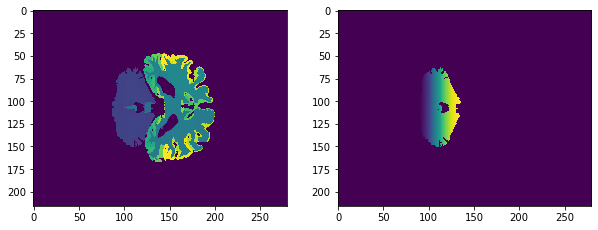

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mid_lab_data[:, 100, :])
axes[1].imshow(ref_roi_mask_int[:, 100, :])

Load baseline PET image

In [11]:
bl_pet_img = nib.load('data/sub-10015124_ses-baseline_desc-static-50-60-pct-niftypet-itr4.nii.gz')
bl_pet_data = bl_pet_img.get_fdata()
bl_pet_img.affine

fu_pet_img = nib.load('data/sub-10015124_ses-followup_desc-static-50-60-pct-niftypet-itr4.nii.gz')
fu_pet_data = fu_pet_img.get_fdata()
fu_pet_img.affine

array([[  -2.0863,    0.    ,    0.    ,  358.8367],
       [   0.    ,    2.0863,    0.    , -356.7505],
       [   0.    ,    0.    ,    2.0312, -135.9531],
       [   0.    ,    0.    ,    0.    ,    1.    ]])

In [12]:
def get_mm_def(def_data,i,j,k):
    x_mm = def_data[i,j,k,0]
    y_mm = def_data[i,j,k,1]
    z_mm = def_data[i,j,k,2]
    return [x_mm,y_mm,z_mm]

def vox2mm(img,i, j, k):
    M = img.affine[:3, :3]
    abc = img.affine[:3, 3]
    """ Return X, Y, Z coordinates for i, j, k """
    return M.dot([i, j, k]) + abc


def mm2vox(img,x, y, z):
    M = npl.inv(img.affine)[:3, :3]
    abc = npl.inv(img.affine)[:3, 3]
    """ Return i, j, k coordinates for x, y, z"""
    vox_array = M.dot([x, y, z]) + abc
    return np.round(vox_array)

get voxel coordinate for each labelled voxel

In [ ]:
nvox=np.count_nonzero(ref_roi_mask_int)
print('number of voxels in region: ' + str(nvox))
n=1

roi_dict = {}
bl_dict = {}
fu_dict = {}
while n <= nvox:
    coord = np.nonzero(ref_roi_mask_int == n)
    i,j,k = coord
    x_mm,y_mm,z_mm = get_mm_def(mid_to_bl_data,int(i),int(j),int(k))
    bl_i,bl_j,bl_k = mm2vox(bl_pet_img,x_mm,y_mm,z_mm)
    x_mm,y_mm,z_mm = get_mm_def(mid_to_fu_data,int(i),int(j),int(k))
    fu_i,fu_j,fu_k = mm2vox(fu_pet_img,x_mm,y_mm,z_mm)
    #print('baseline PET for voxel '+str(n)+' is: '+str(bl_pet_vox))
    #print('followup PET for voxel '+str(n)+' is: '+str(fu_pet_vox))
    
    vox_tup = ([int(bl_i),int(bl_j),int(bl_k)],[int(fu_i),int(fu_j),int(fu_k)])
    if vox_tup not in roi_dict.values():
        #print('unique combination')
        bl_tup = ([int(bl_i),int(bl_j),int(bl_k)])
        fu_tup = ([int(fu_i),int(fu_j),int(fu_k)])
        if bl_tup not in bl_dict.values() and fu_tup not in fu_dict.values():
            roi_dict.update({str(n) : vox_tup})
            bl_dict.update({str(n) : bl_tup})
            fu_dict.update({str(n) : fu_tup})
            #print('added to dict')
        #else:
            #print('baseline or followup voxel already used')
    #else:
        #print('duplicate')
    
    n=n+1

number of voxels in region: 99569


In [27]:
roi_dict

{'1': ([177.0, 161.0, 7.0], [175.0, 162.0, 22.0]),
 '2': ([177.0, 164.0, 7.0], [175.0, 164.0, 22.0]),
 '4': ([174.0, 160.0, 7.0], [172.0, 161.0, 22.0]),
 '5': ([173.0, 160.0, 7.0], [171.0, 161.0, 22.0]),
 '9': ([172.0, 161.0, 7.0], [170.0, 161.0, 22.0]),
 '10': ([178.0, 161.0, 7.0], [176.0, 162.0, 22.0]),
 '12': ([176.0, 161.0, 7.0], [174.0, 162.0, 22.0]),
 '13': ([174.0, 161.0, 7.0], [172.0, 162.0, 22.0]),
 '14': ([173.0, 161.0, 7.0], [171.0, 162.0, 22.0]),
 '18': ([171.0, 161.0, 7.0], [169.0, 162.0, 22.0]),
 '26': ([171.0, 162.0, 7.0], [168.0, 162.0, 22.0]),
 '27': ([177.0, 163.0, 7.0], [175.0, 163.0, 22.0]),
 '29': ([176.0, 162.0, 7.0], [174.0, 163.0, 22.0]),
 '31': ([174.0, 162.0, 7.0], [172.0, 163.0, 22.0]),
 '32': ([173.0, 162.0, 7.0], [171.0, 163.0, 22.0]),
 '34': ([172.0, 162.0, 7.0], [170.0, 163.0, 22.0]),
 '37': ([170.0, 162.0, 7.0], [168.0, 163.0, 22.0]),
 '39': ([178.0, 163.0, 7.0], [176.0, 163.0, 22.0]),
 '49': ([171.0, 163.0, 7.0], [169.0, 163.0, 22.0]),
 '53': ([178.0, 1